# 03 Limiting Element Counts 

By looking at experimental fits, it is apparent that having too few element counts indicates bad fits. If the fit is unsuccessful, it will appear as a flat line with no peaks because no elements were able to be fit. Fits with too few element counts are excluded from the data in subsequent notebooks. 

In [32]:
import h5py
import pyxrfmaps as px 
import numpy as np
import matplotlib.pyplot as plt

In [33]:
element_csv_filename = "../reference/xrf_library.csv"
element_henke_filename = "../reference/henke.xdr"
input_filename = "../../2die_2012_2017.hdf5"

In [34]:
# Initial set up for XRF Maps
px.load_element_info(element_henke_filename, element_csv_filename)
trans = px.io.file.get_FILE_TAGS_TRANSLATION()
fit_rout = px.fitting.routines.nnls()

In [35]:
MIN_ELEMENT_COUNTS = 10_000
MIN_PHOTON_COUNTS = 10_000

## Plotting the Fits

Plots show the poor quality of fits with low element counts. This cell can be stopped early to prevent a long time spent plotting.

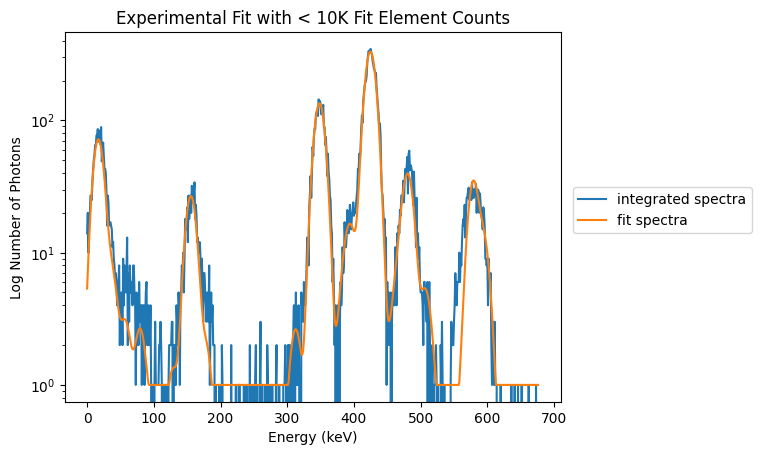

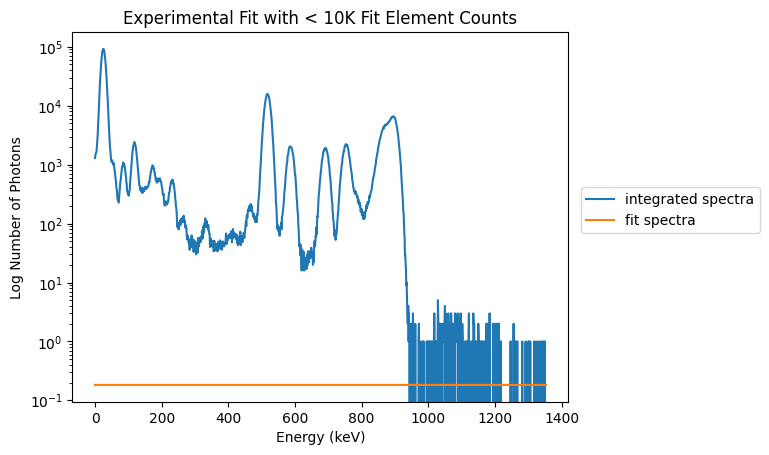

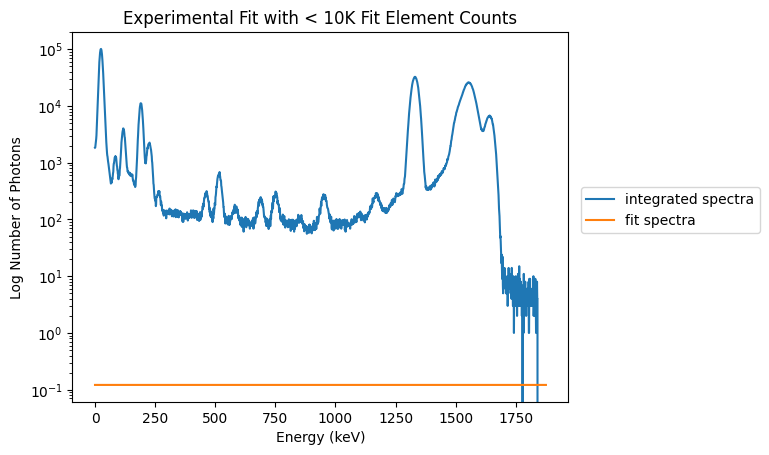

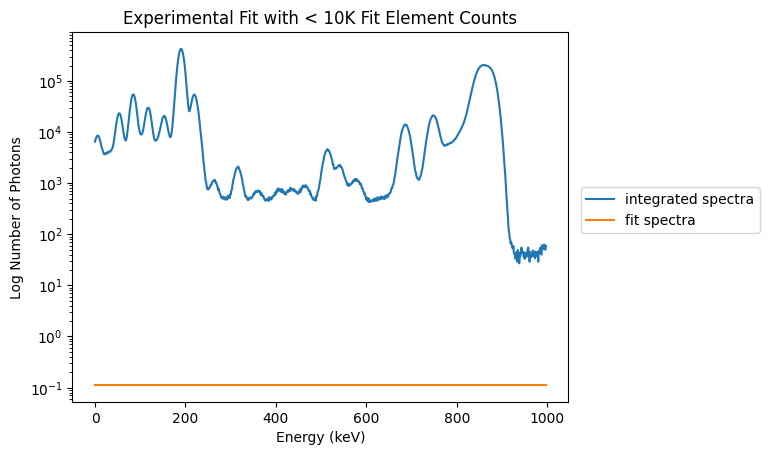

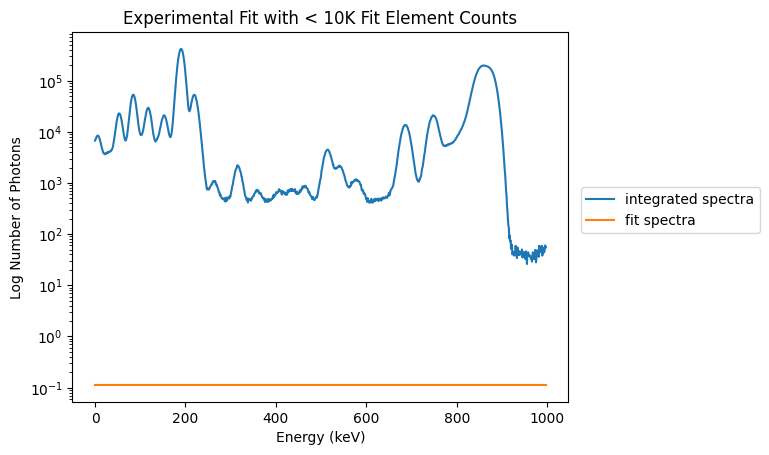

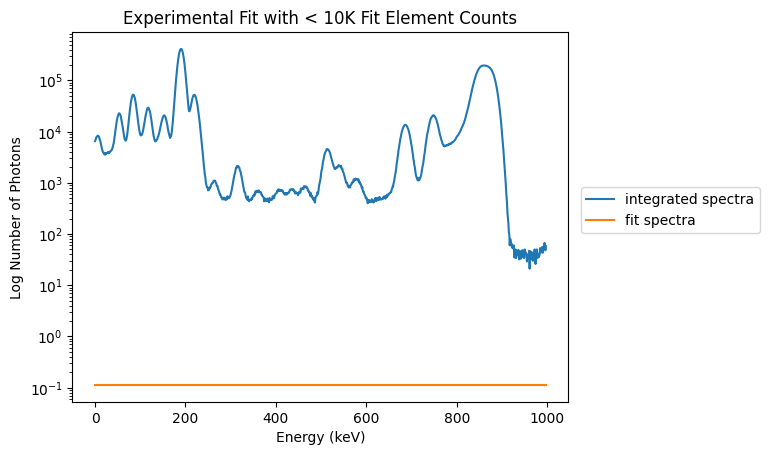

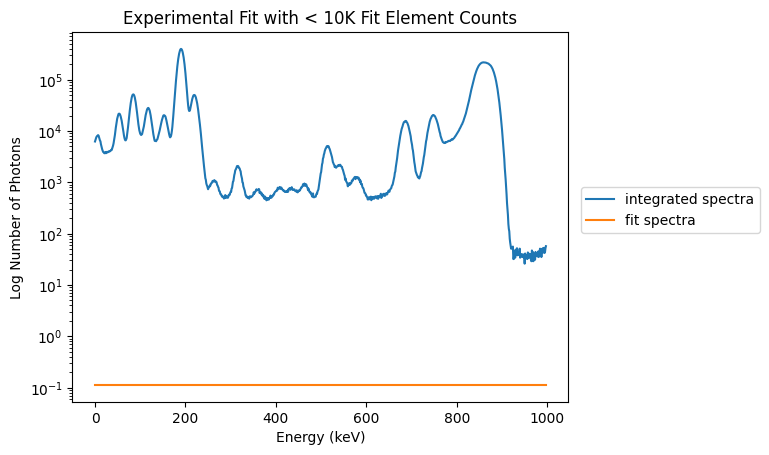

KeyboardInterrupt: 

In [36]:
with h5py.File(input_filename, 'r') as infile:
    for name, h5obj in infile.items():
        # Load dataset
        int_specs = h5obj['int_spectra']
        # Initialize model and fit routine with fit parameters
        for spectra in int_specs:
            photon_count_sum = sum(spectra)
            if photon_count_sum > MIN_PHOTON_COUNTS:
                # Use Gausian Model
                model = px.fitting.models.GaussModel()
                po = px.ParamsOverride()
                
                el = h5obj['elements'][()]
                el = el.decode()        
                el_list = [i.strip() for i in el.split(',')]
                el_list += ['COMPTON_AMPLITUDE', 'COHERENT_SCT_AMPLITUDE']
                    
                po.fill_elements_from_dict(el_list, 'Si')
                param_names = h5obj['fit_param_names'][...]
                param_values = h5obj['fit_param_values'][...]
                param_dict = {}
                for name, value in zip(param_names, param_values):
                    name = name.decode()
                    if name in trans:
                        name = trans[name]
                    param_dict[name] = value
                    po.fit_params.add_parameter(px.Fit_Param(name, value))
                model.update_fit_params_values(po.fit_params)
        
                energy_range = px.get_energy_range(spectra.size, po.fit_params)
                fit_rout.initialize(model, po.elements_to_fit, energy_range)

                # Fit element counts
                element_counts_fit = fit_rout.fit_counts(model, spectra, po.elements_to_fit)
                element_counts_sum = 0
                for name in el_list:
                    if name in element_counts_fit.keys():
                        element_counts_sum += element_counts_fit[name]
                    
                if element_counts_sum < MIN_ELEMENT_COUNTS: 
                    # Get Fit Spectra 
                    fit_spec = fit_rout.fit_spectra(model, spectra, po.elements_to_fit)
                    max_val = np.amax(fit_spec)
                    fit_spec = np.clip(fit_spec, 1, max_val)
                    # Resize int_spec to match fit_spec
                    resize_spectra = spectra[energy_range.min:energy_range.max+1]
                    
                    i_ax = np.linspace(0, resize_spectra.size-1, resize_spectra.size)
                    f_ax = np.linspace(0, fit_spec.size-1, fit_spec.size)
                    fig, axs = plt.subplots()
                    axs.plot(i_ax, resize_spectra, label="integrated spectra")
                    axs.plot(f_ax, fit_spec, label="fit spectra")
                    axs.set_yscale('log')
                    axs.set_ylabel('Log Number of Photons')
                    axs.set_xlabel('Energy (keV)')
                    axs.set_title("Experimental Fit with < 10K Fit Element Counts")
                    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.6))
                    plt.show()

## Filtering the Dataset

Data is filtered to remove experiments with low element counts and saved to csv files. 
It is important to maintain the order the rows are written as the spectra in each row are related to the fit parameters and elements of the same row.

In [30]:
filename = './training_data/02_int_spectra.csv'
with open(filename) as f:
    int_spectra = f.readlines()
    print(len(int_spectra))
filename = './training_data/02_resize_spectra.csv'
with open(filename) as f:
    resize_spectra = f.readlines()
    print(len(resize_spectra))
filename = './training_data/02_fit_spectra.csv'
with open(filename) as f:
    fit_spectra = f.readlines()
    print(len(fit_spectra))
filename = './training_data/02_elements.csv'
with open(filename) as f:
    elements = f.readlines()
    print(len(elements))
filename = './training_data/02_fit_params_standard.csv'
with open(filename) as f:
    fit_params = f.readlines()
    print(len(fit_params))
# Sanity check that the line counts match except for elements and fit params which should have an extra header line

97256
97256
97256
97257
97257


In [31]:
with open('./training_data/03_int_spectra.csv', 'w') as f_int:
    with open('./training_data/03_resize_spectra.csv', 'w') as f_resize:
        with open('./training_data/03_fit_spectra.csv', 'w') as f_fit:
            with open('./training_data/03_elements.csv', 'w') as f_elem:
                with open('./training_data/03_fit_params_standard.csv', 'w') as f_param:
                    # write headers
                    f_elem.write(elements[0])
                    f_param.write(fit_params[0])
                    for i in range(len(int_spectra)):
                        ct = 0
                        e = elements[i + 1].strip().split(',')
                        for j in range(len(e)):
                            ct += float(e[j])
                        if ct > MIN_ELEMENT_COUNTS:
                            f_int.write(int_spectra[i])                            
                            f_resize.write(resize_spectra[i])
                            f_fit.write(fit_spectra[i])
                            f_elem.write(elements[i + 1])
                            f_param.write(fit_params[i + 1])